# Problem 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#read data
X = pd.read_csv("X.csv", header = None)
y = pd.read_csv("y.csv", header = None)

In [3]:
def kflod_split(df, k = 10, stratified = False, random_state = None):
    """
    Args: 
        df: dataframe
        k: int, number of folds, default 10
        stratified: boolean, if True, stratified, otherwise not
        random_state: int or numpy.random.RandomState, optional
    Returns: 
        a list of k dataframes
    """
    res = []
    length = int(df.shape[0]/k)
    df = df.sample(frac = 1, random_state=random_state)
    for i in range(0,k):
        df_new = df[i*length:(i+1)*length]
        res.append(df_new)
    return res

In [4]:
data = pd.concat([X,y],axis = 1)
datum = kflod_split(data,random_state=11)

## (a)  naive Bayes classifier

In [5]:
def Pi(y):
    """
    input:
        y: dataframe
    output:
        pi: float
    """
    y_values = y.iloc[:,0].unique()
    n = y.shape[0]
    pi = {}
    for k in y_values:
        y_k = y.loc[y.iloc[:,0]==k]
        s = y_k.shape[0]
        temp  = s/n
        pi[k] = temp
    return pi

In [6]:
def Lambdas(df):
    """
    input:
        data: dataframe, with y is the last column
    output:
        lambdas: a list of array
    """
    y_values = data.iloc[:,-1].unique()  #get all the values of y
    dfs = {}
    lambdas = {}
    for k in y_values:
        dfs[k] = df.loc[df.iloc[:,-1] == k]
        n = dfs[k].shape[0]
        temp = (dfs[k].iloc[:,0:-1].sum(axis=0)+1)/(n+1)
        temp = np.array(temp)
        lambdas[k] = temp
    return lambdas

In [7]:
def naive_Bayes_classifier(X,y,X_test):
    """
    input: 
        X: dataframe
        y: dataframe
        X_test: dataframe
    output:
        y_predict: dataframe
    """
    y_predict = []
    df = pd.concat([X,y],axis = 1)
    pi = Pi(y)
    lambdas = Lambdas(df)
    for i in range(0,X_test.shape[0]):
        X0 = X_test.iloc[i]    #X0 is one row of X_test
        X0 = np.array(X0)
        y_scores = {}    #calculate the scores for different y_values
        y_values = y.iloc[:,0].unique()  #y_values is the unique values of y e.g:{0,1,2,...,k}
        for k in y_values:
            y_score = pi[k]*np.exp(-sum(lambdas[k]))*np.prod(np.power(lambdas[k],X0))
            y_scores[k] = y_score
        y_scores = pd.Series(y_scores)
        y0 = y_scores.idxmax()    #get the index name of the max score, y0 is the prediction of X0 row
        y_predict.append(y0)
    y_predict = pd.DataFrame(y_predict)   
    return y_predict, lambdas

In [8]:
def confusion_matrix(y_pred,y_test):   #this method is valid when y_values  = [0,1] or y_values = [-1,1]
    """
    input:
        y_pred: numpy array
        y_test: numpy array
        they must be of same shape(n,1)
    output:
        TP: y_pred = 1 and y_test = 1
        FP: y_pred = 1 and y_test = 0
        FN: y_pred = 0 and y_test = 1
        TN: y_pred = 0 and y_test = 0
    """
    if y_pred.shape[0]!=y_test.shape[0]:
        raise ValueError("two dataframe must have the same length!")
    if y_pred.shape[1]!=1 or y_test.shape[1]!=1:
        raise ValueError("this method can only deal with binary classification")
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    y_pred = np.where(y_pred==-1, 0, y_pred)
    y_test = np.where(y_test==-1, 0, y_test)
    for i in range(y_pred.shape[0]):
        if y_pred[i]== 1 and y_test[i]==1:
            TP = TP+1
        elif y_pred[i]== 1 and y_test[i]==0:
            FP = FP+1
        elif y_pred[i]== 0 and y_test[i]==1: 
            FN = FN+1
        elif y_pred[i]== 0 and y_test[i]==0:
            TN = TN+1
        else:
            raise ValueError("please limit the value of y to 0 and 1")
    return TP,FP,FN,TN

In [9]:
cv = 10
TP_all = 0
FP_all = 0  
FN_all = 0
TN_all = 0
lambda_0 = [0]*X.shape[1]
lambda_1 = [0]*X.shape[1]

for i in list(range(cv)):
    test = datum[i]
    train = datum[:i]+datum[(i+1):]
    train = pd.concat(train,ignore_index=True)
    X_test = test.iloc[:,0:-1]
    y_test = test.iloc[:,-1:]
    X_train = train.iloc[:,0:-1]
    y_train = train.iloc[:,-1:]
    y_pred, lambdas = naive_Bayes_classifier(X_train,y_train,X_test)
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    TP,FP,FN,TN = confusion_matrix(y_pred,y_test)   #TP, FP,FN, TN is the value of one fold
    TP_all = TP_all+TP
    FP_all = FP_all+FP
    FN_all = FN_all+FN
    TN_all = TN_all+TN    #TP_all, FP_all,FN_all, TN_all is the value of 10 folds (when cv = 10)
    lambda_0 = [sum(x) for x in zip(lambda_0,lambdas[0])]
    lambda_1 = [sum(x) for x in zip(lambda_1,lambdas[1])]
lambda_0 = [x/cv for x in lambda_0]
lambda_1 = [x/cv for x in lambda_1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in power
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [10]:
TP_all

1713

In [11]:
FP_all

487

In [12]:
FN_all

100

In [13]:
TN_all

2300

In [14]:
prediction_accuracy = (TP_all+TN_all)/data.shape[0]
prediction_accuracy

0.8723913043478261

-|- |Ground |truth
--- | --- | --- | ---
-         |-    | 1 | 0
**Model**|1| 1713 | 487
**prediction**|0 | 100 | 2300

prediction accuracy = 0.8723913043478261

## (b) stem plot

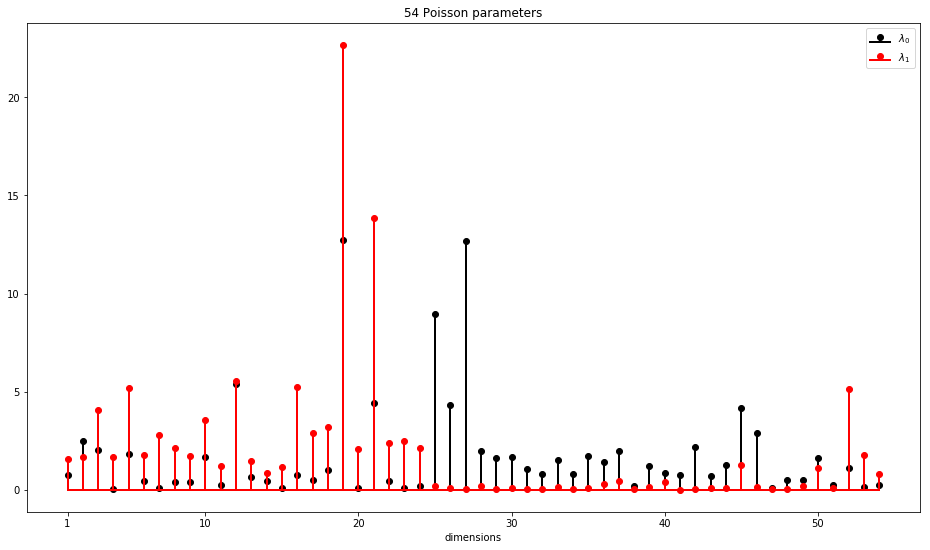

In [15]:
plt.figure(figsize=(16,9))
lambda_0_line = plt.stem(lambda_0, label = "$\lambda_0$ ")
lambda_1_line = plt.stem(lambda_1, label = "$\lambda_1$ ")
plt.setp(lambda_0_line, color='k', linewidth=2)
plt.setp(lambda_1_line, color='r', linewidth=2)
plt.title("54 Poisson parameters")
plt.xticks([0.,  9., 19.,  29.,  39.,  49.],["1","10","20","30","40","50"])
plt.xlabel("dimensions")
plt.legend()

In [16]:
lambda_0[15]

0.7396691120286639

In [17]:
lambda_1[15]

5.213599942325974

In [18]:
lambda_0[51]

1.0960560826179155

In [19]:
lambda_1[51]

5.129292855695839

For dimension 16, $\lambda_1$ = 5.21, is higher than $\lambda_0$ = 0.74. And this dimension represents the word "free". It means in 100 spam email, averagely "free" will appear 521 times; and in 100 non-spam emails, averagely "free" will appear 74 times. In spam email, "free" is 7 times more likely to appear. It is intuitive since many promotion emails contain the word "free".                                 
For dimension 52, $\lambda_1$ = 5.12, is higher than $\lambda_0$ = 1.10. This dimension represents the symbol "!". It means in 100 spam email, averagely "!" will appear 512 times; and in 100 non-spam emails, averagely "!" will appear 110 times. In spam email, "!" is 5 times more likely to appear. It corresponds to our intuition because spam emails tend to use "!" to attract readers. And it non-spam email, people are more likely to use "!" than "free" to express their emotion. So averagely "!" appears more times in non-spam email.

## (c) $k$-NN classifier

In [22]:
def KNN(X,y,X_test,k):
    """
    input: 
        X: dataframe
        y: dataframe
        X_test: dataframe
        k: int
    output:
        y_predict: numpy array
    """
    X = np.array(X)
    y = np.array(y)
    X_test = np.array(X_test)
    y_predict = []
    for i in range(X_test.shape[0]):
        y_near = []
        X0 = X_test[i]
        X0 = np.array(X0)
        y_index = np.argsort(np.sum(abs(X_train-X0),axis = 1))[:k]
        for index in y_index:
            y_near.append(y[index])
        y0 = stats.mode(y_near)[0]
        # here we using stats.mode, thus there are more than one mode, only the smallest(0) will be return
        # considering using the nearest
        y_predict.append(y0)
    y_predict = np.array(y_predict) 
    return y_predict

In [23]:
cv = 10
prediction_accuracys = {}
for k in range(1,21):
    TP_all = 0
    FP_all = 0
    FN_all = 0
    TN_all = 0
    for i in list(range(cv)):
        test = datum[i]
        train = datum[:i]+datum[(i+1):]
        train = pd.concat(train,ignore_index=True)
        X_test = test.iloc[:,0:-1]
        y_test = test.iloc[:,-1:]
        X_train = train.iloc[:,0:-1]
        y_train = train.iloc[:,-1:]
        y_pred = KNN(X_train,y_train,X_test,k)
        y_pred = np.array(y_pred)
        y_test = np.array(y_test)
        TP,FP,FN,TN = confusion_matrix(y_pred,y_test)
        TP_all = TP_all+TP
        FP_all = FP_all+FP
        FN_all = FN_all+FN
        TN_all = TN_all+TN
    prediction_accuracy = (TP_all+TN_all)/(TP_all+FP_all+FN_all+TN_all)
    prediction_accuracys[k] = prediction_accuracy

In [24]:
prediction_accuracys = pd.DataFrame.from_dict(prediction_accuracys, orient="index")

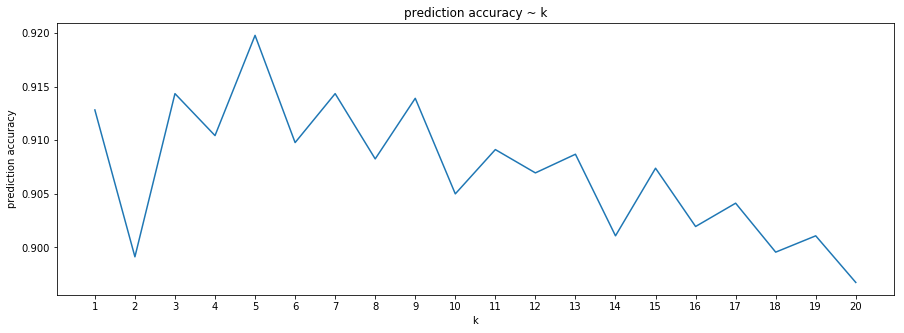

In [25]:
prediction_accuracys.plot(figsize=(15,5), legend=None)
plt.xlabel("k")
plt.ylabel("prediction accuracy")
plt.xticks(np.arange(1,21,1))
_ = plt.title("prediction accuracy ~ k")

##  (d) logistic regression with steepest ascent algorithm

In [5]:
y = y.replace(0,-1)
data = pd.concat([X,y],axis = 1)
datum = kflod_split(data,random_state=11)

In [6]:
#def sigmoid function
def sigmoid(X,w,y):
    """
    Args:
        X: numpy array
        w: numpy array
        y: numpy array
    Returns:
        numpy array
    """
    return np.exp(y*np.dot(X,w))/(1+np.exp(y*np.dot(X,w)))

In [7]:
def derivative_L(X,w,y):
    """
    input:
        X: numpy array
        w: numpy array
        y: numpy array
    output:
        derivative_L: numpy array
    """
    temp = 1-sigmoid(X,w,y)
    temp = temp*y
    temp = temp*X
    temp = np.sum(temp,axis = 0)   #the shape of the result is (55,), so I reshape it
    derivative_L = temp.reshape(w.shape[0],1)
    return derivative_L  

In [8]:
def steepest_ascent(X,y,iteration,stepsize):
    """
    input: 
        X: dataframe
        y: dataframe
        X_test: dataframe
    output:
        w: numpy array shape: X.shape[1]*1
        L: logistic regression objective training function
    """
    X = np.array(X)
    ones = np.ones((X.shape[0],1))
    X = np.hstack((ones,X))
    w = np.zeros((X.shape[1],1))
    y = np.array(y)
    Ls = []
    for i in range(0, iteration):
        temp = derivative_L(X,w,y)
        w = w+stepsize*temp
        #w = w+stepsize*np.sum(((1-sigmoid(X,w,y))*y)*X,axis = 0).reshape(w.shape[0],1) 
        L = np.sum(np.log(sigmoid(X,w,y)))
        Ls.append(L)
    return w, Ls

In [9]:
step_size = 0.01/4600

In [10]:
Ls = {}
cv = 10
for i in list(range(cv)):
    train = datum[:i]+datum[(i+1):]
    train = pd.concat(train,ignore_index=True)
    X_train = train.iloc[:,0:-1]
    y_train = train.iloc[:,-1:]
    w, L = steepest_ascent(X_train, y_train, 1000,step_size)
    Ls[i+1] = L

In [32]:
Ls = pd.DataFrame.from_dict(Ls)

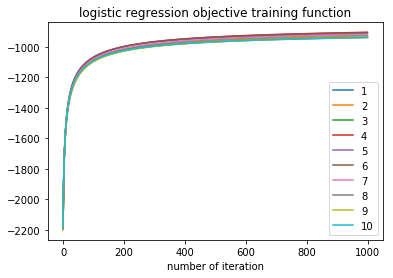

In [33]:
Ls.plot()
plt.xlabel("number of iteration")
plt.title("logistic regression objective training function")
plt.legend()

## (e) logistic regression with Newton’s method

In [34]:
def inverse_hessian(X,w,y):
    """
    Args:
        X: numpy array
        w: numpy array
        y: numpy array
    Returns:
        inverse_hessian: inverse of hessian matrix(second derivative of L); numpy array
    """
    a = np.zeros((55,55))
    np.fill_diagonal(a,pow(10,-2))
    #np.fill_diagonal(a,pow(10,-6))   it still has NaN despite that I add 1e-6 to the diagonal, so I add 1e-2
    hessian = np.zeros((55,55))
    for i in range(0,X.shape[0]):
        temp = sigmoid(X[i],w,y[i])*(sigmoid(X[i],w,y[i])-1)#*y[i]*y[i]
        temp = temp*np.outer(X[i],X[i])    #Note: using outer here, don't use np.dot(np.transpose(X),X), since X.shape = (55,), using dot we will get a number
        hessian = hessian+temp     
    hessian = hessian - a
    inverse_hessian = np.linalg.inv(hessian)
    return inverse_hessian

In [35]:
def newton_method(X,y,iteration):
    """
    Args:
        X: X_train, dataframe
        y: y_train, dataframe
        iteration: number of iterations, int
    Returns:
        w: numpy array shape: X.shape[1]*1
        L: logistic regression objective training function
    """
    X = np.array(X)
    ones = np.ones((X.shape[0],1))
    X = np.hstack((ones,X))
    w = np.zeros((X.shape[1],1))
    y = np.array(y)
    Ls = []
    for i in range(0, iteration):
        L = np.sum(np.log(sigmoid(X,w,y)))
        w = w - np.dot(inverse_hessian(X,w,y),derivative_L(X,w,y))
        Ls.append(L)
        """
        if np.isnan(w_nex).any()==True:     #these code is for breaking the loop earlier
            continue;
        else:
            w_pre = w_nex
        """    
    return w, Ls        

In [36]:
Ls = {}
cv = 10
for i in list(range(cv)):
    train = datum[:i]+datum[(i+1):]
    train = pd.concat(train,ignore_index=True)
    X_train = train.iloc[:,0:-1]
    y_train = train.iloc[:,-1:]
    w, L = newton_method(X_train, y_train, 100)
    Ls[i+1] = L

In [37]:
Ls = pd.DataFrame.from_dict(Ls)

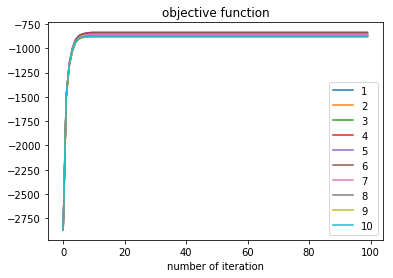

In [38]:
Ls.plot()
plt.xlabel("number of iteration")
plt.title("objective function")
plt.legend()

## (f)

In [39]:
def logistic_prediction(X,w):
    """
    Args:
        X: X_test, dataframe
        w: numpy array
    Returs:
        y_predict: prediction of y, numpy array
    """
    X = np.array(X)
    ones = np.ones((X.shape[0],1))
    X = np.hstack((ones,X))
    y_predict = np.exp(np.dot(X,w))/(1+np.exp(np.dot(X,w)))
    y_predict[y_predict>=0.5] = 1
    y_predict[y_predict<0.5] = -1     
    return y_predict

In [40]:
TP_all = 0
FP_all = 0
FN_all = 0
TN_all = 0    
for i in list(range(cv)):
    test = datum[i]
    train = datum[:i]+datum[(i+1):]
    train = pd.concat(train,ignore_index=True)
    X_train = train.iloc[:,0:-1]
    y_train = train.iloc[:,-1:]
    X_test = test.iloc[:,0:-1]
    y_test = test.iloc[:,-1:]    
    w, _ = newton_method(X_train, y_train, 100)
    y_pred = logistic_prediction(X_test,w)
    y_test = np.array(y_test)    
    TP,FP,FN,TN = confusion_matrix(y_pred,y_test)   #TP, FP,FN, TN is the value of one fold
    TP_all = TP_all+TP
    FP_all = FP_all+FP
    FN_all = FN_all+FN
    TN_all = TN_all+TN

In [41]:
TP_all

1592

In [42]:
FP_all

140

In [43]:
FN_all

221

In [44]:
TN_all

2647

In [45]:
prediction_accuracy = (TP_all+TN_all)/data.shape[0]
prediction_accuracy

0.9215217391304348

 -|- |Ground |truth 
--- | --- | --- | ---
-         |-    | 1 | 0
**Model**|1| 1592 | 140
**prediction**|0 | 221 | 2647

prediction accuracy =0.9215217391304348